<a href="https://colab.research.google.com/github/JakubMarac/implementation-of-missing-data/blob/main/projekt_adn_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import missingno as msno
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from pathlib import Path

from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [ ]:
#wgranie danych
df_test = pd.read_csv('/content/drive/MyDrive/analiza-danych-niekompletnych/pzn-rent-test.csv')
df_train = pd.read_csv("/content/drive/MyDrive/analiza-danych-niekompletnych/pzn-rent-train.csv")
df_sample = pd.read_csv("/content/drive/MyDrive/analiza-danych-niekompletnych/pzn-sample-sub.csv")


In [ ]:
RANDOM_STATE = 123
np.random.seed(RANDOM_STATE)

In [ ]:
print("TRAIN shape:", df_train.shape)
print("TEST  shape:", df_test.shape)
print("SAMPLE shape:", df_sample.shape)
df_train.head()

TRAIN shape: (11297, 36)
TEST  shape: (4842, 35)
SAMPLE shape: (4842, 2)


,id,ad_title,date_activ,date_modif,date_expire,individual,price,flat_area,flat_rooms,flat_furnished,...,flat_dishwasher,flat_fridge,flat_cooker,flat_oven,flat_internet,flat_television,flat_anti_blinds,flat_monitoring,flat_closed_area,quarter
0,2508,"Mieszkanie, 49 m², Poznań",2019-05-30,2019-05-30,2019-06-29,False,1500,49.0,2.0,False,...,False,False,False,False,False,False,False,False,False,Rataje
1,2557,"z Ogrodem i tarasem, w świetnej lokalzacji",2019-06-01,2019-06-01,2019-07-01,False,2500,65.0,3.0,False,...,False,False,False,False,NaN,False,False,False,False,Rataje
2,10616,"Mieszkanie, 30 m², Poznań",2020-04-17,2020-04-23,2020-05-17,False,1250,30.0,1.0,NaN,...,NaN,False,False,False,False,False,False,False,False,Piątkowo
3,8889,Nowy pokój w centrum 10m2,2020-02-06,2020-02-10,2020-03-07,False,900,10.0,1.0,False,...,False,False,False,False,True,False,False,True,False,Wilda
4,12721,"2 pokoje, balkon, miejsce postojowe, ul.Goethego",2020-06-22,2020-06-26,2020-07-22,False,1750,47.0,2.0,False,...,False,False,False,False,False,False,False,False,True,Strzeszyn


In [ ]:
# 2. Raport sentyneli -999
def report_sentinel_minus999(df, name):
    mask = (df == -999)
    cols_with_999 = mask.any()
    cols = cols_with_999[cols_with_999].index.tolist()
    print(f"=== {name}: kolumny z -999 ===")
    for col in cols:
        cnt = mask[col].sum()
        print(f"{col}: {cnt} wystąpień")
    if not cols:
        print("brak -999")
    print()

report_sentinel_minus999(df_train, "TRAIN")
report_sentinel_minus999(df_test,  "TEST")

=== TRAIN: kolumny z -999 ===
flat_area: 1069 wystąpień

=== TEST: kolumny z -999 ===
flat_area: 477 wystąpień



In [ ]:
# Podstawowa tabela braków (tylko info, nie używane dalej)
na_cnt = df_train.isna().sum().sort_values(ascending=False)
na_pct = (df_train.isna().mean() * 100).sort_values(ascending=False).round(2)
missing_summary = pd.DataFrame({"n_missing": na_cnt, "pct_missing": na_pct})
print("=== Missing summary (top 10) ===")
print(missing_summary.head(10))

=== Missing summary (top 10) ===
                   n_missing  pct_missing
flat_internet           3569        31.59
flat_for_students       1804        15.97
flat_closed_area        1804        15.97
flat_balcony            1368        12.11
quarter                 1368        12.11
flat_garage             1317        11.66
flat_furnished          1317        11.66
flat_garden             1317        11.66
flat_dishwasher         1317        11.66
flat_rooms              1227        10.86


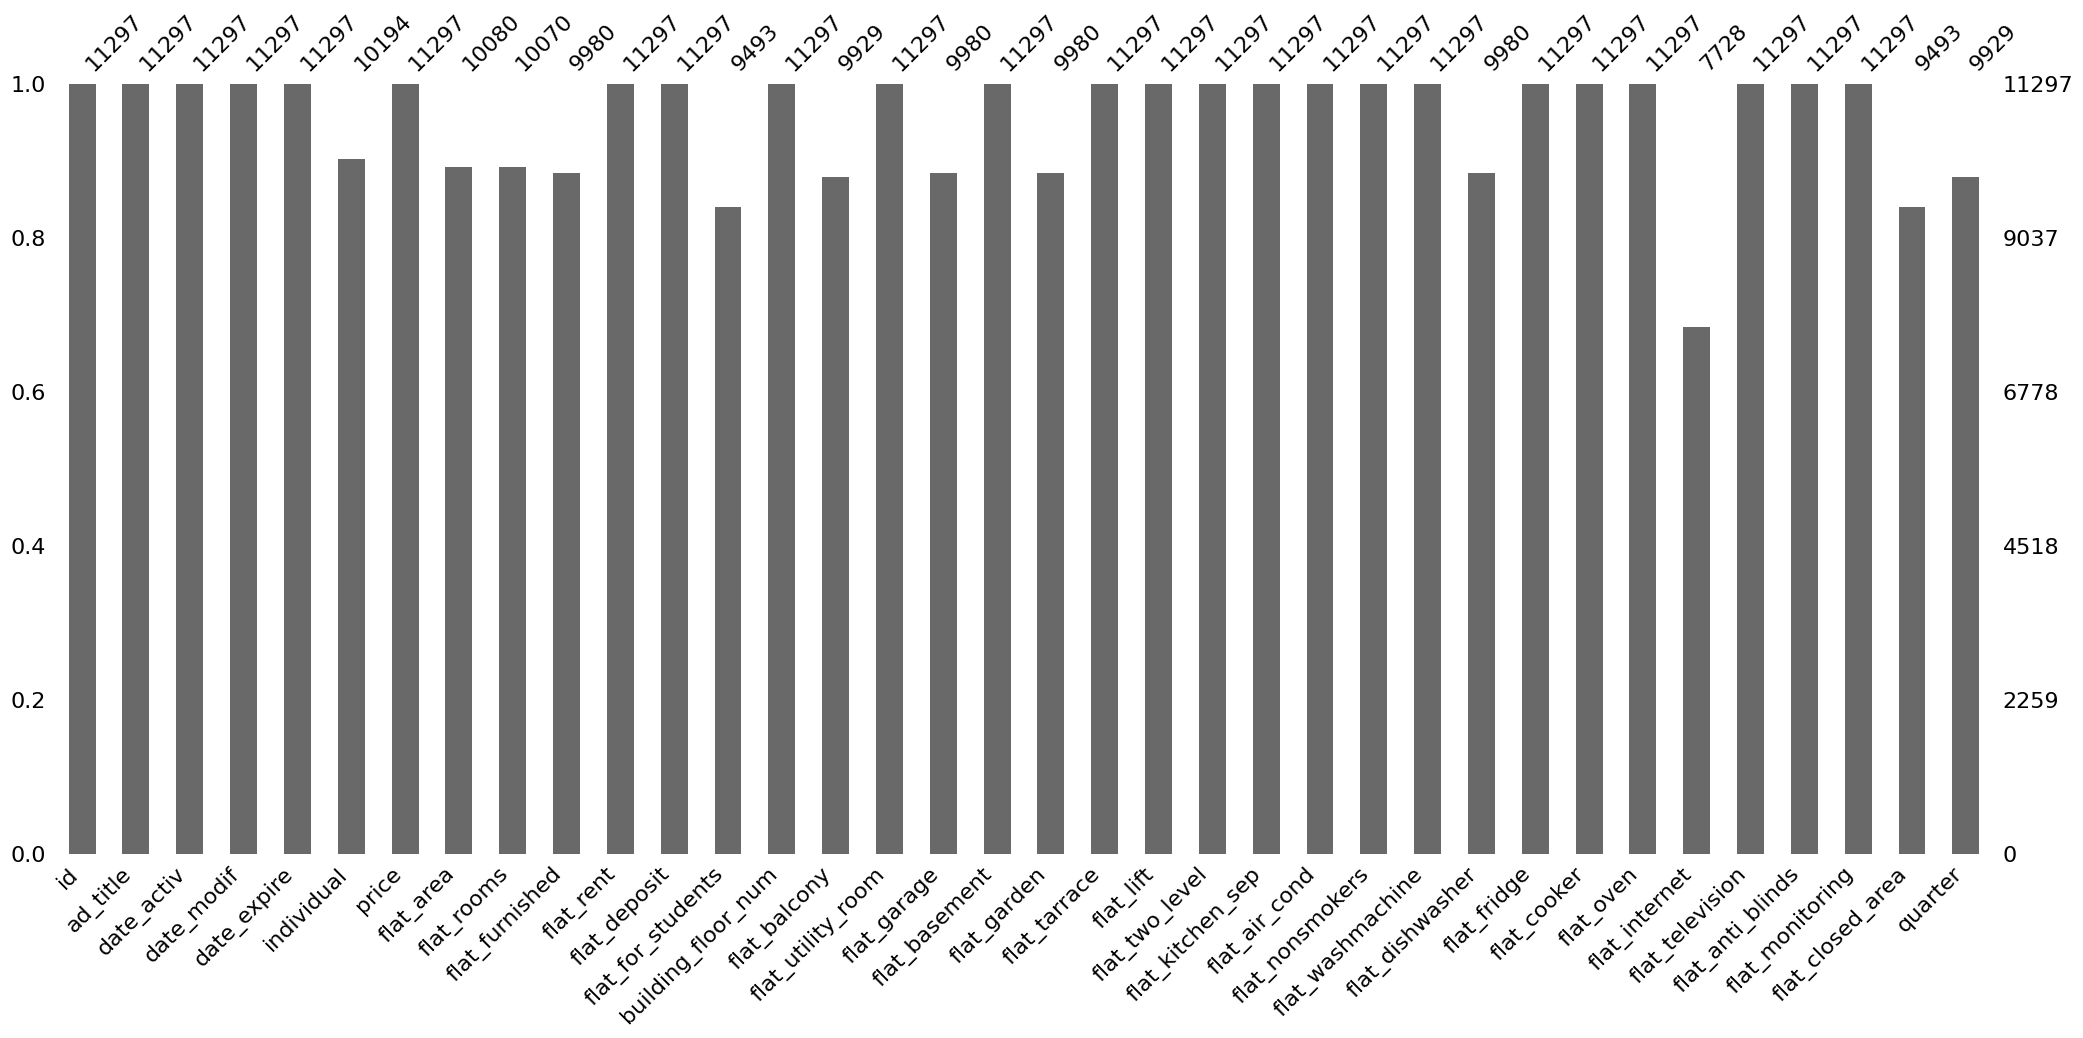

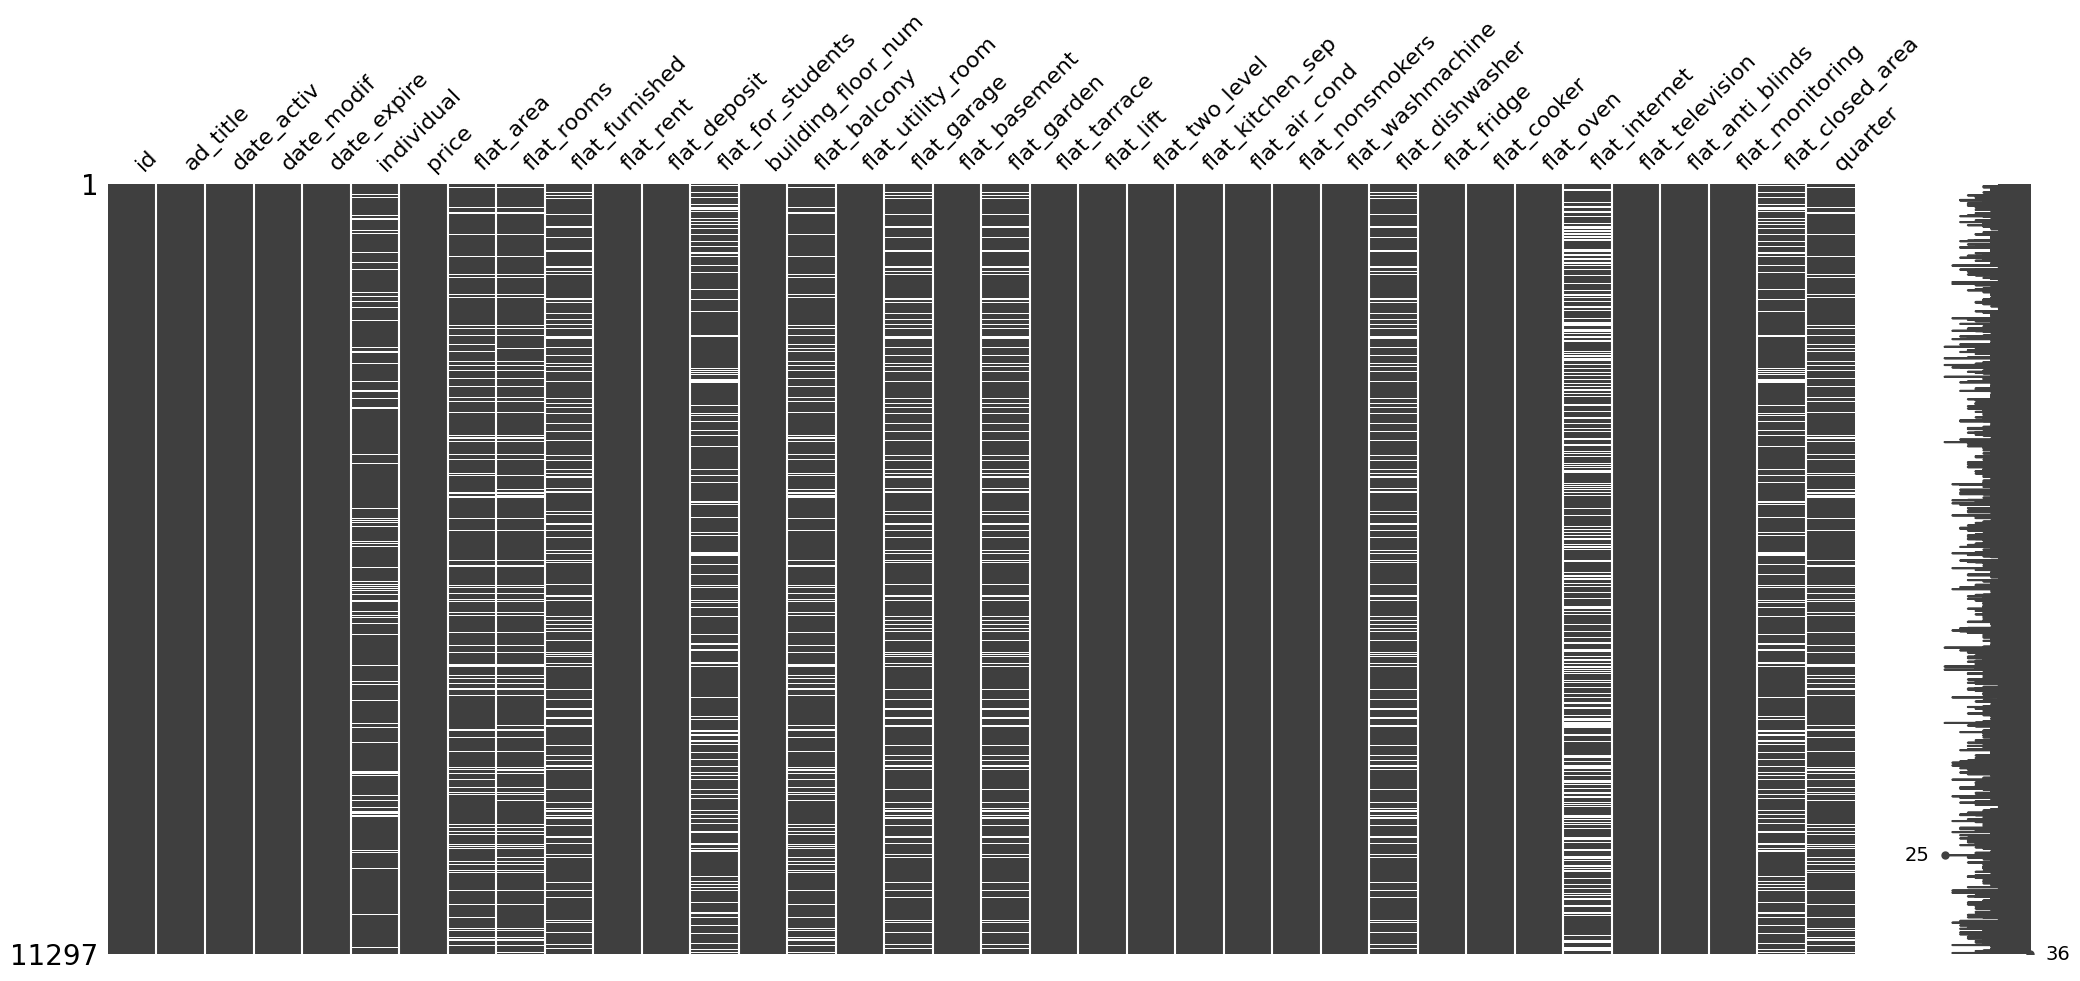

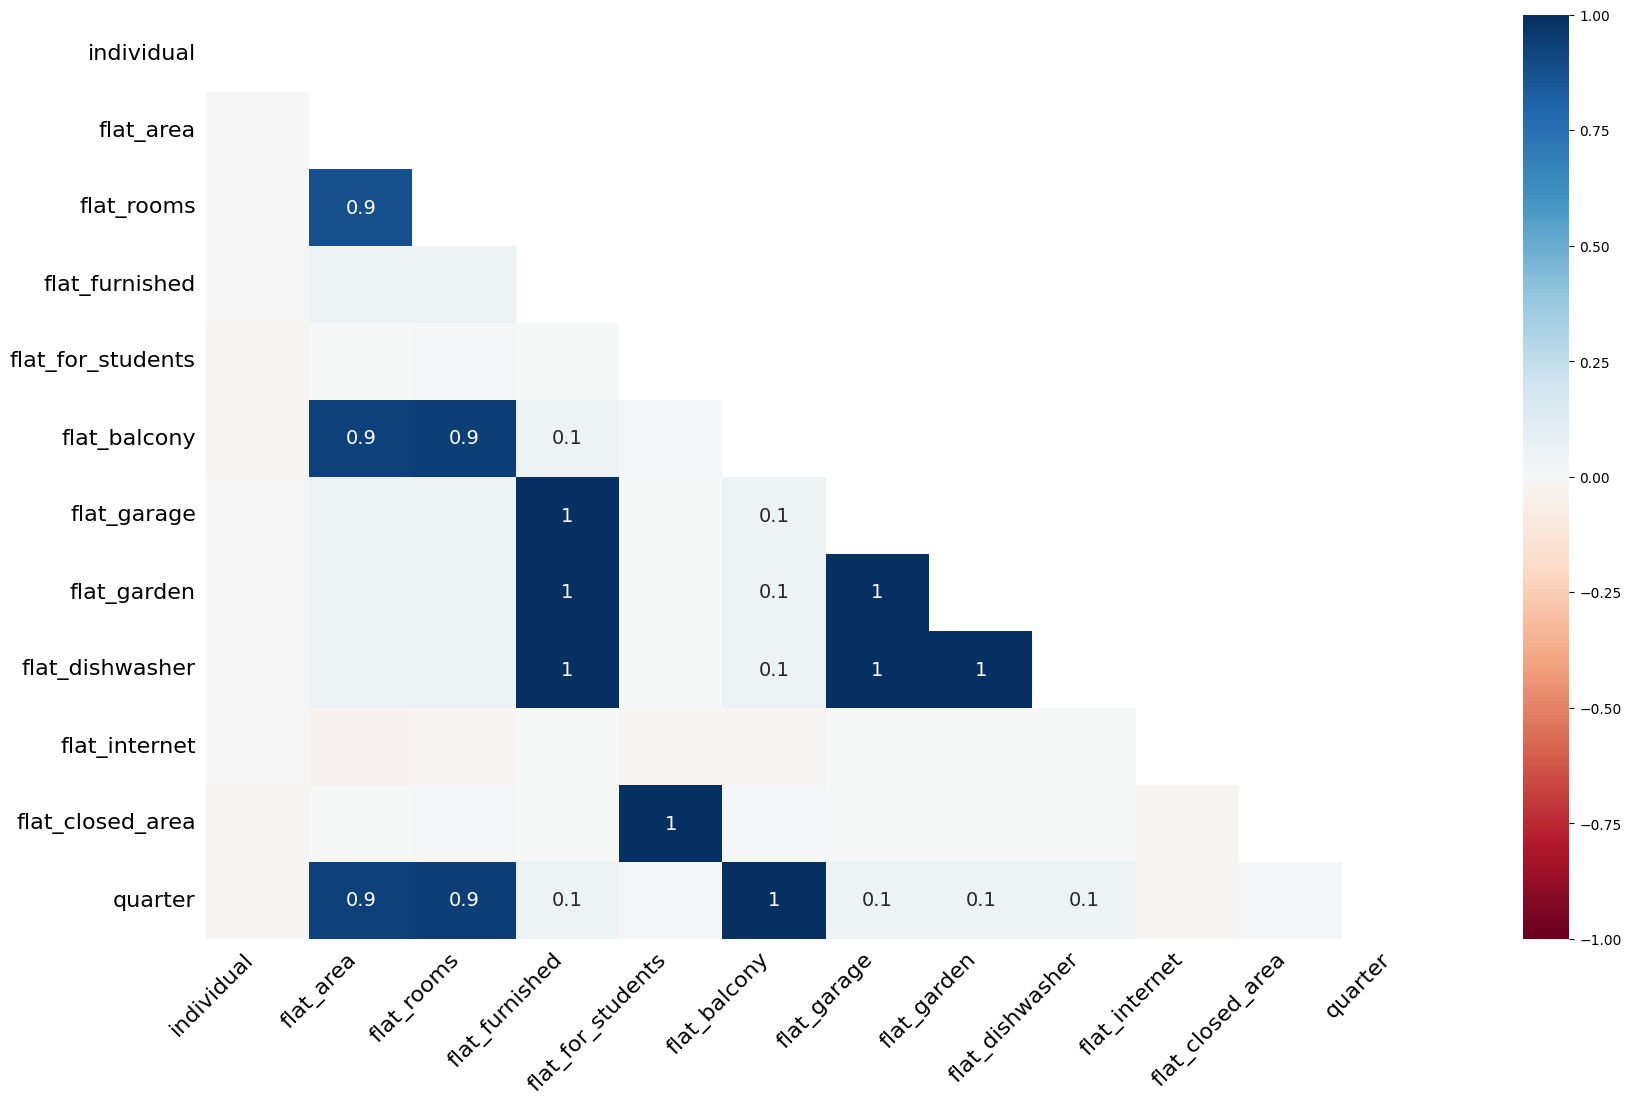

In [ ]:
# Wizualizacja braków (opcjonalnie)
msno.bar(df_train)
plt.show()
msno.matrix(df_train)
plt.show()
msno.heatmap(df_train)
plt.show()

In [ ]:
# 3. Konwersja dat + sanity check na datach
date_cols = ["date_activ", "date_modif", "date_expire"]

for df in [df_train, df_test]:
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors="coerce")

print("=== Typy dat po konwersji (TRAIN) ===")
print(df_train[date_cols].dtypes)

# kolejnosc dat (tylko informacyjnie)
cond_bad_order = (
    (df_train["date_activ"] > df_train["date_modif"]) |
    (df_train["date_modif"] > df_train["date_expire"])
)
df_bad_dates = df_train[cond_bad_order]
print("Złe kolejności dat (TRAIN):", df_bad_dates.shape[0])

=== Typy dat po konwersji (TRAIN) ===
date_activ     datetime64[ns]
date_modif     datetime64[ns]
date_expire    datetime64[ns]
dtype: object
Złe kolejności dat (TRAIN): 1


In [ ]:
# czas trwania ogłoszenia + anomalie
for df_name, df in [("train", df_train), ("test", df_test)]:
    duration = (df["date_expire"] - df["date_activ"]).dt.days

    df["listing_duration"] = duration
    df["duration_anomaly"] = (duration >= 365).astype(int)
    df.loc[duration >= 365, "listing_duration"] = np.nan

    print(f"=== {df_name} listing_duration ===")
    print(duration.describe())
    print("<=0 dni:", (duration <= 0).sum())
    print(">=365 dni:", (duration >= 365).sum())
    print()


=== train listing_duration ===
count    11297.000000
mean       131.048597
std        273.346986
min         12.000000
25%         30.000000
50%         30.000000
75%         66.000000
max       2184.000000
dtype: float64
<=0 dni: 0
>=365 dni: 1096

=== test listing_duration ===
count    4842.000000
mean      136.641057
std       285.119926
min        25.000000
25%        30.000000
50%        30.000000
75%        73.000000
max      2039.000000
dtype: float64
<=0 dni: 0
>=365 dni: 474



In [ ]:
# 4. Sanity check: price / flat_rent / flat_deposit
for df_name, df in [("train", df_train), ("test", df_test)]:
    print(f"=== {df_name} price & rent sanity ===")
    print("price <= 0:", (df["price"] <= 0).sum() if "price" in df.columns else "brak")
    print("flat_rent < 0:", (df["flat_rent"] < 0).sum())
    print("flat_deposit < 0:", (df["flat_deposit"] < 0).sum())
    print()

=== train price & rent sanity ===
price <= 0: 0
flat_rent < 0: 0
flat_deposit < 0: 0

=== test price & rent sanity ===
price <= 0: brak
flat_rent < 0: 0
flat_deposit < 0: 0



In [ ]:
# anomalia: flat_rent > price (tylko train, bo price tylko tam)
mask_anomaly_rent = df_train["flat_rent"] > df_train["price"]
print("Liczba anomalii price/rent (flat_rent > price):", mask_anomaly_rent.sum())

df_train["rent_over_price_anomaly"] = mask_anomaly_rent.astype(int)
# USTAWIAMY TYLKO flat_rent NA NaN, price zostawiamy jako target
df_train.loc[mask_anomaly_rent, "flat_rent"] = np.nan
df_test["rent_over_price_anomaly"] = 0

# checkpoint
print("Po czyszczeniu rent vs price – ile NaN w flat_rent (TRAIN):",
      df_train["flat_rent"].isna().sum())


Liczba anomalii price/rent (flat_rent > price): 18
Po czyszczeniu rent vs price – ile NaN w flat_rent (TRAIN): 18


In [ ]:
# 5. Cleaning flat_area
for df_name, df in [("train", df_train), ("test", df_test)]:
    print(f"=== {df_name} flat_area przed czyszczeniem ===")
    print(df["flat_area"].describe())
    print("flat_area <= 5:", (df["flat_area"] <= 5).sum())
    print("flat_area > 200:", (df["flat_area"] > 200).sum())
    print()

def clean_flat_area(df):
    area = df["flat_area"]

    df["flat_area_sentinel"]   = (area == -999).astype(int)
    df["flat_area_too_small"]  = (area <= 5).astype(int)
    df["flat_area_too_big"]    = (area > 200).astype(int)

    mask_anomaly = (area == -999) | (area <= 5) | (area > 200)
    df.loc[mask_anomaly, "flat_area"] = np.nan
    return df

df_train = clean_flat_area(df_train)
df_test  = clean_flat_area(df_test)

for df_name, df in [("train", df_train), ("test", df_test)]:
    print(f"=== {df_name} flat_area po czyszczeniu ===")
    print(df["flat_area"].describe())
    print("NaN w flat_area:", df["flat_area"].isna().sum())
    print()


=== train flat_area przed czyszczeniem ===
count    10080.000000
mean       -61.930383
std        323.362380
min       -999.000000
25%         34.000000
50%         45.500000
75%         55.000000
max       1000.000000
Name: flat_area, dtype: float64
flat_area <= 5: 1069
flat_area > 200: 3

=== test flat_area przed czyszczeniem ===
count    4335.000000
mean      -66.113749
std       330.067254
min      -999.000000
25%        34.000000
50%        45.000000
75%        54.000000
max      2200.000000
Name: flat_area, dtype: float64
flat_area <= 5: 477
flat_area > 200: 1

=== train flat_area po czyszczeniu ===
count    9008.000000
mean       49.080233
std        17.727854
min         8.000000
25%        38.000000
50%        47.500000
75%        56.000000
max       196.000000
Name: flat_area, dtype: float64
NaN w flat_area: 2289

=== test flat_area po czyszczeniu ===
count    3857.000000
mean       48.669925
std        16.817682
min         8.000000
25%        38.000000
50%        47.000000


In [ ]:
def clean_flat_rooms(df):
    rooms = df["flat_rooms"]
    df["flat_rooms_invalid"] = (rooms <= 0).astype(int)
    df["flat_rooms_large"]   = (rooms > 10).astype(int)

    df.loc[rooms <= 0, "flat_rooms"] = np.nan
    df.loc[rooms > 10, "flat_rooms"] = np.nan
    return df

df_train = clean_flat_rooms(df_train)
df_test  = clean_flat_rooms(df_test)

# area_per_room dla TRAIN i TEST
for df in [df_train, df_test]:
    df["area_per_room"] = df["flat_area"] / df["flat_rooms"]

print("=== TRAIN area_per_room przed czyszczeniem ===")
print(df_train["area_per_room"].describe())
print("area_per_room < 5:", (df_train["area_per_room"] < 5).sum())
print("area_per_room > 80:", (df_train["area_per_room"] > 80).sum())
print()

def clean_area_per_room(df):
    apr = df["area_per_room"]
    df["area_per_room_small"] = (apr < 5).astype(int)
    df["area_per_room_large"] = (apr > 80).astype(int)
    df.loc[(apr < 5) | (apr > 80), "area_per_room"] = np.nan
    return df

df_train = clean_area_per_room(df_train)
df_test  = clean_area_per_room(df_test)

print("=== TRAIN area_per_room po czyszczeniu ===")
print(df_train["area_per_room"].describe())
print("NaN w area_per_room:", df_train["area_per_room"].isna().sum())
print()

=== TRAIN area_per_room przed czyszczeniem ===
count    8105.000000
mean       24.237482
std         6.284857
min         1.125000
25%        20.000000
50%        23.435000
75%        27.000000
max        80.000000
Name: area_per_room, dtype: float64
area_per_room < 5: 21
area_per_room > 80: 0

=== TRAIN area_per_room po czyszczeniu ===
count    8084.000000
mean       24.291348
std         6.203247
min         5.000000
25%        20.000000
50%        23.500000
75%        27.000000
max        80.000000
Name: area_per_room, dtype: float64
NaN w area_per_room: 3213



In [ ]:
# 7. Furnished inconsistency (niemeblowane + sprzęty)
def fix_furnished_inconsistency(df):
    equip_cols = [
        "flat_fridge", "flat_cooker", "flat_oven",
        "flat_washmachine", "flat_dishwasher", "flat_television"
    ]
    has_equipment = df[equip_cols].sum(axis=1) > 0

    mask_incons = (df["flat_furnished"] == False) & has_equipment
    df["furnished_inconsistency"] = mask_incons.astype(int)
    df.loc[mask_incons, "flat_furnished"] = np.nan
    return df

df_train = fix_furnished_inconsistency(df_train)
df_test  = fix_furnished_inconsistency(df_test)

print("Nieumeblowane, ale sprzęty (TRAIN):",
      df_train["furnished_inconsistency"].sum())
print("NaN w flat_furnished (TRAIN):",
      df_train["flat_furnished"].isna().sum())
print()


Nieumeblowane, ale sprzęty (TRAIN): 1844
NaN w flat_furnished (TRAIN): 3161



In [ ]:
# 8. Cleaning quarter (bez słownika, rare -> other)
print(df_train["quarter"].value_counts(dropna=False).head(15))
print("missing quarter train:", df_train["quarter"].isna().sum())
print("missing quarter test:", df_test["quarter"].isna().sum())

for df in [df_train, df_test]:
    df["quarter_missing"] = df["quarter"].isna().astype(int)
    q = (
        df["quarter"]
        .astype(str)
        .str.lower()
        .str.strip()
    )
    q = q.replace("nan", np.nan)
    df["quarter"] = q

# rare -> other (na podstawie TRAIN)
counts = df_train["quarter"].value_counts(dropna=True)
rare = counts[counts < 20].index

for df in [df_train, df_test]:
    df["quarter_clean"] = df["quarter"].where(~df["quarter"].isin(rare), other="other")
    df["quarter_clean"] = df["quarter_clean"].fillna("unknown")

print("=== quarter_clean value_counts (TRAIN, top 15) ===")
print(df_train["quarter_clean"].value_counts().head(15))
print()


quarter
Grunwald        1473
NaN             1368
Centrum          944
Jeżyce           855
Rataje           771
Wilda            767
Piątkowo         699
Stare Miasto     675
Winogrady        643
Łazarz           464
Nowe Miasto      335
Naramowice       334
Górczyn          174
Sołacz           152
Dębiec           118
Name: count, dtype: int64
missing quarter train: 1368
missing quarter test: 562
=== quarter_clean value_counts (TRAIN, top 15) ===
quarter_clean
grunwald        1473
unknown         1368
centrum          944
jeżyce           855
rataje           771
wilda            767
piątkowo         699
stare miasto     675
winogrady        643
łazarz           464
nowe miasto      335
naramowice       334
other            191
górczyn          174
sołacz           152
Name: count, dtype: int64



In [ ]:
# 9. Kopia do feature engineering
train_fe = df_train.copy()
test_fe  = df_test.copy()


In [ ]:
# 9.1. Cechy z dat (UWAGA: listing_duration już jest policzone i wyczyszczone)
for df in [train_fe, test_fe]:
    df["time_to_modif"] = (df["date_modif"] - df["date_activ"]).dt.days
    df["activ_year"]    = df["date_activ"].dt.year
    df["activ_month"]   = df["date_activ"].dt.month
    df["activ_dow"]     = df["date_activ"].dt.dayofweek

In [ ]:
# 9.2. Cechy z tytułu ogłoszenia
for df in [train_fe, test_fe]:
    df["ad_title_filled"] = df["ad_title"].fillna("")
    df["ad_title_len"]    = df["ad_title_filled"].str.len()
    df["ad_title_words"]  = df["ad_title_filled"].str.split().str.len()

In [ ]:
# 9.3. Markery braków dla kluczowych numeryków
marker_cols = ["flat_area", "flat_rooms", "flat_rent", "flat_deposit", "building_floor_num"]
for df in [train_fe, test_fe]:
    for col in marker_cols:
        df[col + "_missing"] = df[col].isna().astype(int)


In [ ]:
# Checkpoint: ilość NaN po FE
print("NaN summary (TRAIN_FE, top 15):")
print(train_fe.isna().sum().sort_values(ascending=False).head(15))


NaN summary (TRAIN_FE, top 15):
flat_internet        3569
area_per_room        3213
flat_furnished       3161
flat_rooms           2342
flat_area            2289
flat_for_students    1804
flat_closed_area     1804
quarter              1368
flat_balcony         1368
flat_garage          1317
flat_dishwasher      1317
flat_garden          1317
individual           1103
listing_duration     1096
flat_rent              18
dtype: int64


In [ ]:
# 10. Przygotowanie danych do modelu
TARGET = "price"
ID_COL = "id"

y = train_fe[TARGET]
X = train_fe.drop(columns=[TARGET])

# kolumny do dropnięcia (daty surowe + surowy tytuł + pomocnicze)
cols_to_drop = date_cols + ["ad_title", "ad_title_filled", "quarter"]
X = X.drop(columns=cols_to_drop)
test_model = test_fe.drop(columns=cols_to_drop)

# num_cols = wszystkie float/int poza ID
num_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
num_cols = [c for c in num_cols if c not in [ID_COL]]

# cat_cols = reszta nie-numerycznych (bool, object)
cat_cols = X.columns.difference(num_cols + [ID_COL]).tolist()

print("Liczba zmiennych numerycznych:", len(num_cols))
print("Liczba zmiennych kategorycznych:", len(cat_cols))

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)


Liczba zmiennych numerycznych: 26
Liczba zmiennych kategorycznych: 28


In [ ]:
# 11. Preprocessing: imputacja + kodowanie
numeric_imputer = IterativeImputer(
    estimator=ExtraTreesRegressor(
        n_estimators=50,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    max_iter=10,
    initial_strategy="median",
    random_state=RANDOM_STATE
)

numeric_transformer = Pipeline(steps=[
    ("imputer", numeric_imputer)
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

In [ ]:
# 12. Model bazowy: Linear Regression (log-target)
y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)

model_lin = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", LinearRegression())
])

model_lin.fit(X_train, y_train_log)

y_pred_log_lin = model_lin.predict(X_valid)
y_pred_lin = np.expm1(y_pred_log_lin)

mse_lin  = mean_squared_error(y_valid, y_pred_lin)
rmse_lin = np.sqrt(mse_lin)
mae_lin  = mean_absolute_error(y_valid, y_pred_lin)

print(f"Linear Regression: RMSE={rmse_lin:.2f}, MAE={mae_lin:.2f}")

Linear Regression: RMSE=377.47, MAE=264.65


In [ ]:
# 13. XGBoost – tuning + early stopping (log-target)
y_full_log = np.log1p(y)

# dopasowanie preprocessora na całym X
preprocessor.fit(X)

X_train_t = preprocessor.transform(X_train)
X_valid_t = preprocessor.transform(X_valid)
X_full_t  = preprocessor.transform(X)
X_test_t  = preprocessor.transform(test_model)

xgb_base = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    reg_lambda=1.0,
    reg_alpha=0.0,
    gamma=0.0,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    tree_method="hist",
)

param_distributions = {
    "n_estimators":     [400, 600, 800, 1000],
    "learning_rate":    [0.01, 0.03, 0.05, 0.1],
    "max_depth":        [3, 4, 5, 6, 8],
    "min_child_weight": [1, 3, 5, 7],
    "subsample":        [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_lambda":       [0.1, 1.0, 10.0],
    "reg_alpha":        [0.0, 0.1, 1.0],
    "gamma":            [0.0, 0.1, 1.0],
}

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=40,
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

random_search.fit(X_train_t, y_train_log)

print("Najlepsze parametry (log-target):")
print(random_search.best_params_)

best_cv_mse  = -random_search.best_score_
best_cv_rmse = np.sqrt(best_cv_mse)
print(f"CV RMSE na skali log(price): {best_cv_rmse:.4f}")

best_xgb_no_es = random_search.best_estimator_

y_valid_pred_log = best_xgb_no_es.predict(X_valid_t)
y_valid_pred     = np.expm1(y_valid_pred_log)

mse_valid  = mean_squared_error(y_valid, y_valid_pred)
rmse_valid = np.sqrt(mse_valid)
mae_valid  = mean_absolute_error(y_valid, y_valid_pred)

print(f"XGB log-target (bez ES) – hold-out: RMSE={rmse_valid:.2f}, MAE={mae_valid:.2f}")


Fitting 3 folds for each of 40 candidates, totalling 120 fits
Najlepsze parametry (log-target):
{'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.03, 'gamma': 0.0, 'colsample_bytree': 0.6}
CV RMSE na skali log(price): 0.1610
XGB log-target (bez ES) – hold-out: RMSE=302.53, MAE=207.34


In [ ]:
# 14. XGBoost z early stopping
best_params = random_search.best_params_.copy()

xgb_es = XGBRegressor(
    **best_params,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    tree_method="hist",
    eval_metric="rmse",
    early_stopping_rounds=50
)

xgb_es.fit(
    X_train_t, y_train_log,
    eval_set=[(X_valid_t, y_valid_log)],
    verbose=False
)

print("Best iteration (ES):", xgb_es.best_iteration)

y_pred_log = xgb_es.predict(X_valid_t)
y_pred = np.expm1(y_pred_log)

mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_valid, y_pred)

print("XGB + ES – RMSE:", rmse)
print("XGB + ES – MAE:", mae)

Best iteration (ES): 632
XGB + ES – RMSE: 302.84269070344095
XGB + ES – MAE: 207.5011749267578


In [ ]:
# 15. Finalny model na pełnym train + predykcja na test
n_best = xgb_es.best_iteration

best_params_clean = best_params.copy()
best_params_clean.pop("n_estimators", None)

xgb_full = XGBRegressor(
    **best_params_clean,
    n_estimators=n_best,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    tree_method="hist",
    eval_metric="rmse"
)

xgb_full.fit(X_full_t, y_full_log)

y_pred_log_test = xgb_full.predict(X_test_t)
y_pred_test = np.expm1(y_pred_log_test)

submission_log_es = pd.DataFrame({
    "ID": test_model[ID_COL],
    "TARGET": y_pred_test
})

submission_log_es.to_csv("submission_xgb_log_es.csv", index=False)
print("Zapisano submission_xgb_log_es.csv")

print(submission_log_es.shape)
print(submission_log_es.head())
print(submission_log_es.isna().sum())


Zapisano submission_xgb_log_es.csv
(4842, 2)
   ID       TARGET
0   4  1852.299072
1   5  1195.957031
2   9  1320.667969
3  20  1728.701660
4  23  3023.781250
ID        0
TARGET    0
dtype: int64
